<a href="https://colab.research.google.com/github/AritraStark/E2E_GSOC_2022/blob/main/E2E_eval_task_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Common Task 2. Deep Learning based Quark-Gluon Classification :**

Datasets: https://cernbox.cern.ch/index.php/s/hqz8zE7oxyPjvsL

Description 125x125 matrices (three channel images) for two classes of particles
quarks and gluons impinging on a calorimeter.
For description of 1st dataset please refer to the link provided for the dataset.

Please use a Convolutional Neural Network (CNN) architecture of your choice to
achieve the highest possible classification on this dataset (in your preferred choice offramework for example: Tensorflow/Keras or Pytorch). 

Please provide a Jupyter notebook that shows your solution.

Downloading datasets:

In [1]:
!wget https://cernbox.cern.ch/index.php/s/hqz8zE7oxyPjvsL/download
!mkdir data
!7z x -o/content/data download

--2022-04-04 00:09:42--  https://cernbox.cern.ch/index.php/s/hqz8zE7oxyPjvsL/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.53.28, 188.184.97.72, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘download’

download                [         <=>        ] 690.93M  26.3MB/s    in 33s     

2022-04-04 00:10:19 (21.2 MB/s) - ‘download’ saved [724495360]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 724495360 bytes (691 MiB)

Extracting archive: download
--
Path = download
Type = tar
Physical Size = 724495360
Headers Size = 2560
Code Page = UTF-8

  0%     16% - QCDToGGQQ_IMGjet_RH1all_je

Setting up imports:

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import gc
import os
from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, plot_roc_curve, auc, roc_curve
from itertools import cycle
!pip install fastparquet


In [4]:
files=os.listdir("/content/data")
print(files)

['QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet', 'QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet', 'QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet']


In [2]:
pf = ParquetFile('/content/data/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet') 
first_rows = next(pf.iter_batches(batch_size = 12000, columns=['X_jets', 'y'])) 
df = pa.Table.from_batches([first_rows]).to_pandas() 
del first_rows

Retrieve details of the dataset and then split the data:

In [3]:
X_dataset = np.array(np.array(np.array(df['X_jets'].tolist()).tolist()).tolist())
y_dataset = df['y'].to_numpy()
print(X_dataset.shape, y_dataset.shape)
del df

(12000, 3, 125, 125) (12000,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.2, random_state=9)
X_train = np.moveaxis(X_train, 1, -1)
X_test = np.moveaxis(X_test, 1, -1)
gc.collect()
del X_dataset, y_dataset
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9600, 125, 125, 3), (9600,), (2400, 125, 125, 3), (2400,))

Define the CNN model:

In [5]:
num_classes = 1
input_shape = (125, 125, 3)
model = tf.keras.applications.ResNet101V2(
          include_top=True, 
          weights=None,
          input_shape=input_shape,
          classes=1,
          classifier_activation='sigmoid'
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 125, 125, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 131, 131, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 63, 63, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 65, 65, 64)   0           ['conv1_conv[0][0]']   

Defining callback:

In [6]:
filepath="classifier_weights2-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint1 = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

Compiling and Fitting the model with training data:

In [7]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=15, 
                    callbacks=callbacks_list,
                    validation_data = (X_test, y_test)
)

Epoch 1/15
300/300 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.6789
Epoch 1: val_accuracy improved from -inf to 0.49750, saving model to classifier_weights2-improvement-01-0.50.hdf5
300/300 [==============================] - 95s 241ms/step - loss: 0.6341 - accuracy: 0.6789 - val_loss: 1.2781 - val_accuracy: 0.4975
Epoch 2/15
300/300 [==============================] - ETA: 0s - loss: 0.5845 - accuracy: 0.7097
Epoch 2: val_accuracy did not improve from 0.49750
300/300 [==============================] - 68s 228ms/step - loss: 0.5845 - accuracy: 0.7097 - val_loss: 1.0632 - val_accuracy: 0.3817
Epoch 3/15
300/300 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.7222
Epoch 3: val_accuracy improved from 0.49750 to 0.58250, saving model to classifier_weights2-improvement-03-0.58.hdf5
300/300 [==============================] - 72s 242ms/step - loss: 0.5684 - accuracy: 0.7222 - val_loss: 0.8672 - val_accuracy: 0.5825
Epoch 4/15
300/300 [========

Plotting the results: 

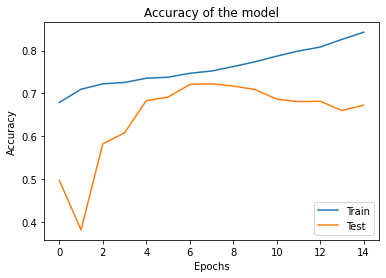

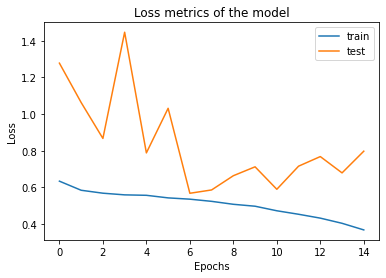

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss metrics of the model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Checking the performance of the model on training data and predicitons:

In [9]:
best_epoch=np.argmax(history.history['val_accuracy'])
best_acc=np.max(history.history['val_accuracy'])
model.load_weights('/content/classifier_weights2-improvement-08-0.72.hdf5')

Classification Report and ROC AUC score on test data:

In [10]:
predictions = model.predict(X_test)
bin =[0 if p<0.5 else 1 for p in predictions]
print(classification_report(y_test,bin))


              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74      1231
         1.0       0.74      0.67      0.70      1169

    accuracy                           0.72      2400
   macro avg       0.72      0.72      0.72      2400
weighted avg       0.72      0.72      0.72      2400



In [11]:
print("ROC AUC:")
roc_auc_score(y_test, bin)


ROC AUC:


0.7211944916016868

No handles with labels found to put in legend.


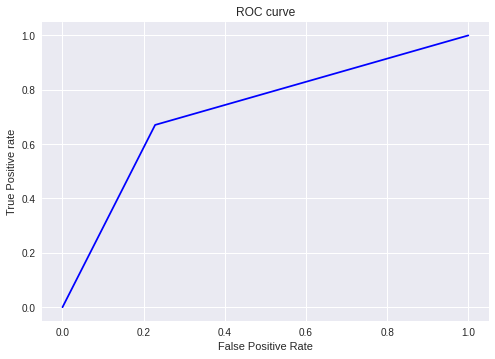

In [12]:
fpr, tpr, thresh = roc_curve(y_test, bin, pos_label=1)
plt.style.use('seaborn')
plt.plot(fpr, tpr,color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();


References: 


*   [Quark-Gluon Jet Discrimination Using Convolutional
Neural Networks](https://arxiv.org/pdf/2012.02531.pdf)
*   [Using Deep Learning to Discriminate Between Quark
and Gluon Jets](https://www.desy.de/f/students/2018/reports/EvansTyler.pdf)
*   [Discriminating quark/gluon jets 
with deep learning](https://indico.cern.ch/event/661284/contributions/2699312/attachments/1521324/2376721/ML_Workshop.pdf)
*   [End-to-end jet classification of quarks and gluons with the CMS Open Data](https://www.sciencedirect.com/science/article/pii/S0168900220307002)



